# Modeling orogenic system using FastScape: 3. Compare to analytical solutions

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

Any numerical model needs to be tested against an analytical solution to check its accuracy. For this, we will compare the FastScape solution to the steady-state profile of a river channel following the SPL.

Assuming steady-state means that:

$$\frac{\partial h}{\partial t}=0=U-K_fA^mS^n$$

if we neglect diffusion. Using Hack's law to relate drainage area to distance along the stream, $L-s$, i.e., measured from the divide:

$$A=k(L-s)^p$$

we get:

$$S=\frac{\partial h}{\partial s}=(U/K_fk^m)^{1/n}(L-s)^{-mp/n}$$

which we can solve for $h$ as a function of $s$:

$$h = h_0\frac{1-(1-s/L)^{1-mp/n}}{1-mp/n}$$

where:

$$h_0=(U/K_fk^m)^{1/n}L^{1-mp/n}$$

See Appendix in [Braun et al, 2015](https://esurf.copernicus.org/articles/3/1/2015/esurf-3-1-2015.pdf) for a full derivation. This solution is a simple power law of $s$ that has a shape that only depends on the ratio $mp/n$, as shown in the following figure

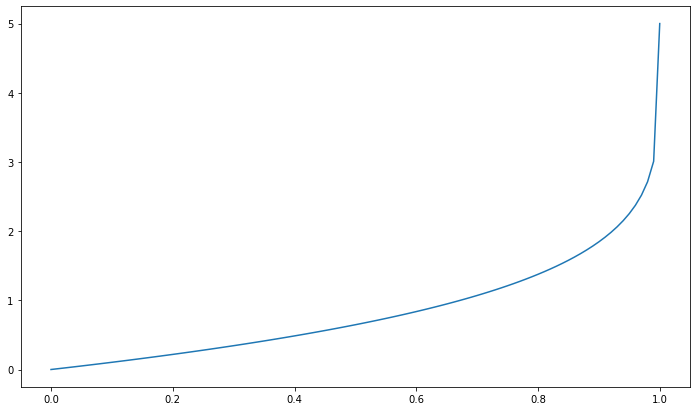

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

m = 0.4
n = 1
p = 2

fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(12,7))

ax.plot(np.linspace(0,1,101),(1-(1-np.linspace(0,1,101))**(1-m*p/n))/(1-m*p/n));

## Compare FastScape to steady-state profile

To compare FastScape to the analytical steady-state solution we will run a new experiment using the following setup:
1. create a new model derived from the *basic_model* from which we will drop the *diffusion* process;
2. use your own set of model parameters (length, resolution, $m$, $n$, $K_f$, $U$, etc.)
2. run the landscape to steady-state; for this you need to run the model for a long time;
3. extract from it the largest river profile using a set of tools (functions) that are provided to you (see *Tools.py*);
4. for this you will need to extract the drainage area, the receiver and donor information from the last time step in FastScape
5. use a new set of bounday conditions (2 opposing looped boundaries, one fixed and one reflective);
6. only store the last time step.

In [2]:
import xsimlab as xs # modeling framework used for FastScape development
import xarray as xr # xarray is a python package to work with labelled multi-dimensional arrays
%load_ext xsimlab.ipython

from fastscape.models import basic_model

spl_model = basic_model.drop_processes('diffusion')

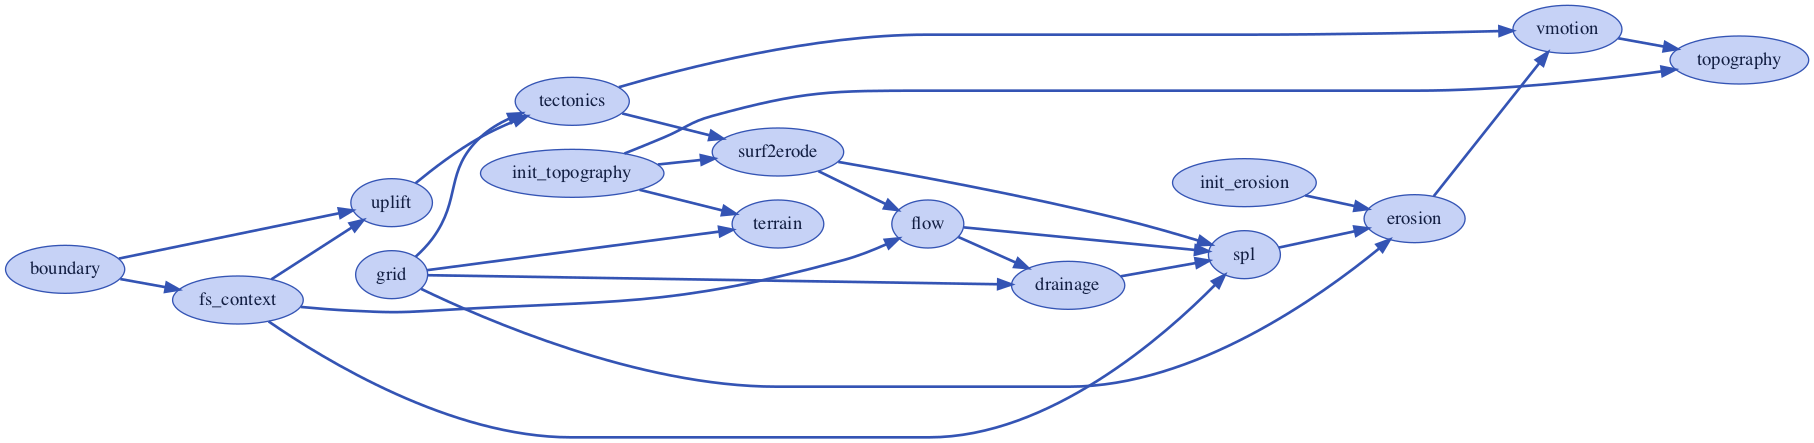

In [3]:
spl_model.visualize()


Now you can build your own setup

In [4]:
# %create_setup spl_model --default --verbose


And here is the "solution"; note that we have also extracted from the model information about the dononrs and the receivers that will be needed to extract information from the solution to compare to the analytical solution

In [5]:
# %create_setup spl_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=spl_model,
    clocks={'time': np.linspace(0,2e7,101),
           'out': np.linspace(0,2e7,11)},
    master_clock="time",
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101,101],
        # total grid length in (y, x)
        'grid__length': [1e5,1e5],
        # node status at borders
        'boundary__status': ['fixed_value','core','looped','looped'],
        # uplift rate
        'uplift__rate': 1e-3,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-7,
        # drainage area exponent
        'spl__area_exp': 0.8,
        # slope exponent
        'spl__slope_exp': 2,
        # random seed
        'init_topography__seed': 1234,
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'flow__nb_donors': 'out',
        'flow__donors': 'out',
        'flow__receivers': 'out'
    }
)


Let's run the model and visualize it

In [6]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=spl_model)

             0% | initialize 

In [7]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(ds_out.out[-1])

app.show()

Output(layout=Layout(height='640px'))

Let's extract from the model output all the information necessary to extract the longest river profile; this includes the receiver array, the donor array, the number of donors array and the area array. We will also need the $x$- and $y$-coordinates of the nodes.

There is a small issue in the xarray-simlab package that does not properly recover/transfer integer variables. So a little fix is needed to create integer arrays that will be used later in this notebook

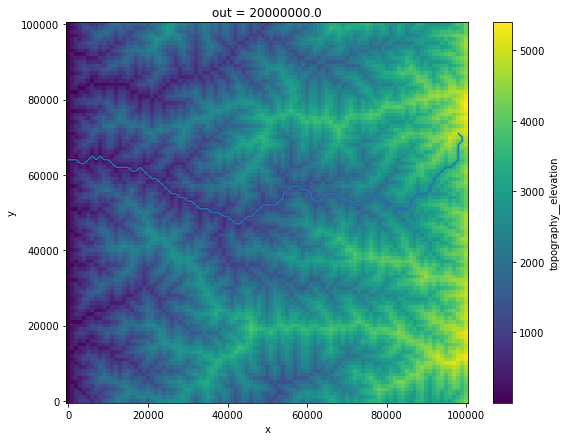

In [8]:
rec = ds_out.flow__receivers.isel(out=-1).values.astype(int)
rec = np.where(rec>0,rec,0)
ndon = ds_out.flow__nb_donors.isel(out=-1).values.astype(int)
don = ds_out.flow__donors.isel(out=-1).values.astype(int)
area = ds_out.drainage__area.isel(out=-1).values.flatten()
h = ds_out.topography__elevation.isel(out=-1).values.flatten()

x = ds_out.x.values
y = ds_out.y.values
U = ds_out.uplift__rate.values
Kf = ds_out.spl__k_coef.values
m = ds_out.spl__area_exp.values
n = ds_out.spl__slope_exp.values
p = 2
k = 0.67

import Tools as tls
river = tls.find_largest_river (area, don, ndon)
s = tls.find_s_coordinate (river, x, y)
chi = tls.find_chi (river, s, area, m/n)
slope = tls.find_slopes (h, x, y, rec)

X,Y = np.meshgrid(x,y)

fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(9,7))

ds_out.topography__elevation.isel(out=-1).plot()

plt.plot(X.flatten()[river], Y.flatten()[river])

Let's compare the river profile to the analytical solution

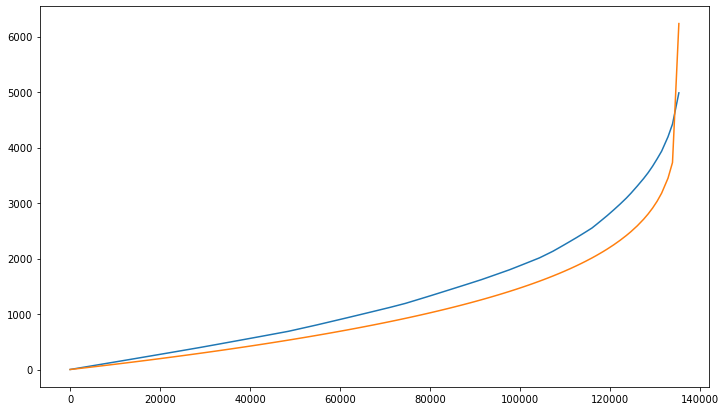

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(12,7))

ax.plot(s, h[river])

L=s[-1]
hmax = (U/Kf/k**m)**(1/n)*L**(1-m*p/n)
analytical_h = (1 - (1-s/L)**(1-m*p/n))*hmax/(1-m*p/n)
ax.plot(s, analytical_h)

The difference is due to Hack's law; let's check it...

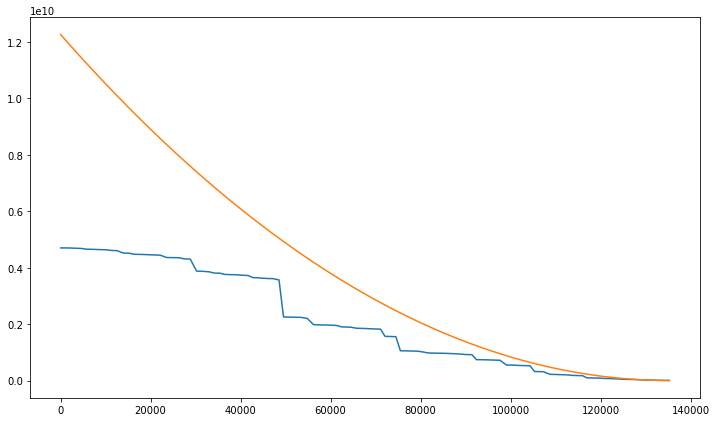

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(12,7))

ax.plot(s,area[river])
ax.plot(s, k*(L-s)**p)

# Using the $\chi$ parameter

[Perron and Royden, 2013](https://onlinelibrary.wiley.com/doi/abs/10.1002/esp.3302) introduced the $\chi$ parameter (or coordinate) which when used instead of $s$ to plot the river profile transforms it into a linear segment, if it has reached steady-state.

$\chi$ is defined as:

$$\chi(s)=\int_0^s(\frac{A_0}{A(s)})^{m/n}\ ds$$

where $A_0$ is a reference drainage area, usually taken as 1. We provide with a function in *Tools.py* to extract $\chi$ from a landform, using the drainage area.

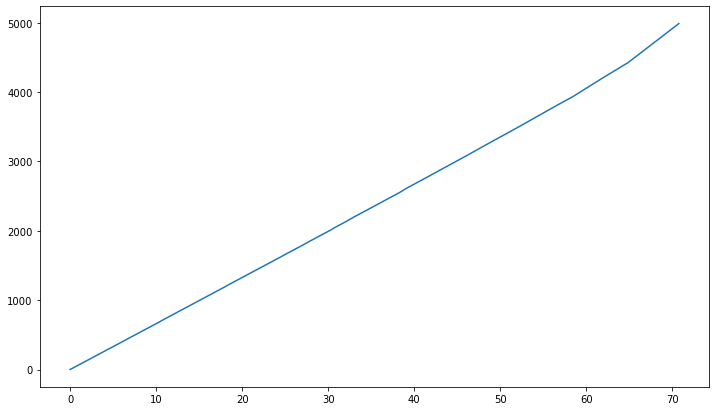

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(12,7))

ax.plot(chi, ds_out.topography__elevation.isel(out=-1).values.flatten()[river])

# Checking the Slope-Area relationship

At steady-state, one can write (according to the SPL) that:

$$S=(U/K_f)^{1/n}A^{-m/n}$$

Plotting the logarithm of slope against the logarithm of drainage area should therefore yield a linear relationship, the slope of which should be equal to the *concavity* ($m/n$). The intercept $(U/K_k)^{1/n}$ is called the profile *steepness* or $k_s$.

Let's these values by regressing the logarithm of slope against the logarithm of drainage area anc comparing the slope and intercept to their expected values.

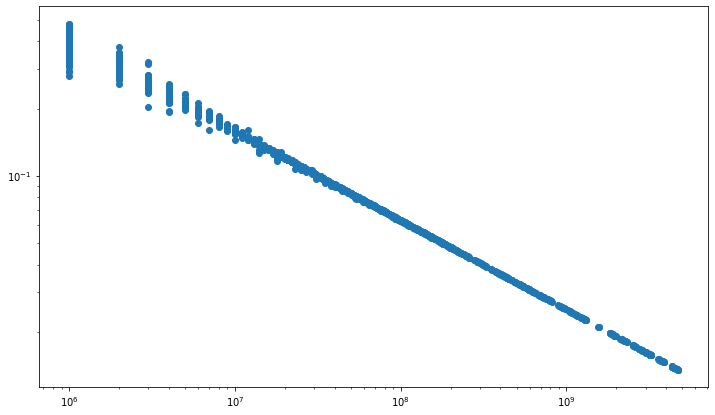

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex=False, sharey=True, figsize=(12,7))

ax.loglog(area, slope, 'o')

In [13]:
import scipy.stats as stats

logslope = np.log10(slope[slope>0])
logarea = np.log10(area[slope>0])
res = stats.linregress(logarea, logslope)
print('Concavity=', -res[0], 'ksn=', 10**res[1])
print('Input concavity=', m/n, 'Input ksn =', (U/Kf)**(1/n))

Concavity= 0.4000073142551546 ksn= 100.03994012942485
Input concavity= 0.4 Input ksn = 100.0
